### Regression analysis section:

Here we'll use our cleaned dataset and perform regression analysis to predict our target variable, house prices.

In [2]:
# standard imports
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# stat and prob imports
import probscale
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

# modelling imports
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

pd.options.display.max_columns = None
%matplotlib inline

While we've cleaned our dataset already, we stll need to perform some quick analysis to 1)confirm our dataset contains no missings and 2) check for multicollinearity. This analysis is covered below:

In [3]:
df = pd.read_csv("data/engineered_data.csv")
df.head()

,SalePrice,LnSalePrice,LandContour_Lvl,LandContour_Low,LandContour_HLS,LandContour_Bnk,flatContour,hasGarage,Bathrooms,BldingType_TwnhsE,BldingType_Twnhs,BldingType_Duplex,BldingType_2fmCon,BldingType_1Fam,streetIsPaved,closeToAmentity,YrSold_2010,YrSold_2009,YrSold_2008,YrSold_2007,YrSold_2006,pop_density,closeToRailorRoad,LocationProxy,Age,Mo Sold,Garage Area,Fireplaces,TotRms AbvGrd,Kitchen AbvGr,Bedroom AbvGr,Gr Liv Area,Central Air,Overall Cond,Overall Qual,Lot Area,Lot Frontage,kitchen_Ex
0,215000,12.278393,1,0,0,0,1,1,1.0,0,0,0,0,1,1,0,1,0,0,0,0,3,0,2,62,5,528.0,2,7,1,3,1656,1,5,6,31770,141.0,0
1,105000,11.561716,1,0,0,0,1,1,1.0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,2,61,6,730.0,0,5,1,2,896,1,6,5,11622,80.0,0
2,172000,12.055250,1,0,0,0,1,1,1.5,0,0,0,0,1,1,0,1,0,0,0,0,3,0,2,64,6,312.0,0,6,1,3,1329,1,6,6,14267,81.0,0
3,244000,12.404924,1,0,0,0,1,1,2.5,0,0,0,0,1,1,0,1,0,0,0,0,3,0,2,54,4,522.0,2,8,1,3,2110,1,5,7,11160,93.0,1
4,189900,12.154253,1,0,0,0,1,1,2.5,0,0,0,0,1,1,0,1,0,0,0,0,3,0,3,25,3,482.0,1,6,1,3,1629,1,5,5,13830,74.0,0


In [4]:
# check for missing values
df.isnull().sum()

SalePrice            0
LnSalePrice          0
LandContour_Lvl      0
LandContour_Low      0
LandContour_HLS      0
LandContour_Bnk      0
flatContour          0
hasGarage            0
Bathrooms            0
BldingType_TwnhsE    0
BldingType_Twnhs     0
BldingType_Duplex    0
BldingType_2fmCon    0
BldingType_1Fam      0
streetIsPaved        0
closeToAmentity      0
YrSold_2010          0
YrSold_2009          0
YrSold_2008          0
YrSold_2007          0
YrSold_2006          0
pop_density          0
closeToRailorRoad    0
LocationProxy        0
Age                  0
Mo Sold              0
Garage Area          1
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Bedroom AbvGr        0
Gr Liv Area          0
Central Air          0
Overall Cond         0
Overall Qual         0
Lot Area             0
Lot Frontage         0
kitchen_Ex           0
dtype: int64

In [5]:
# drop the one missing variable in feature garage area 
df.dropna(inplace=True)

In [6]:
print(df.isnull().values.any())

False


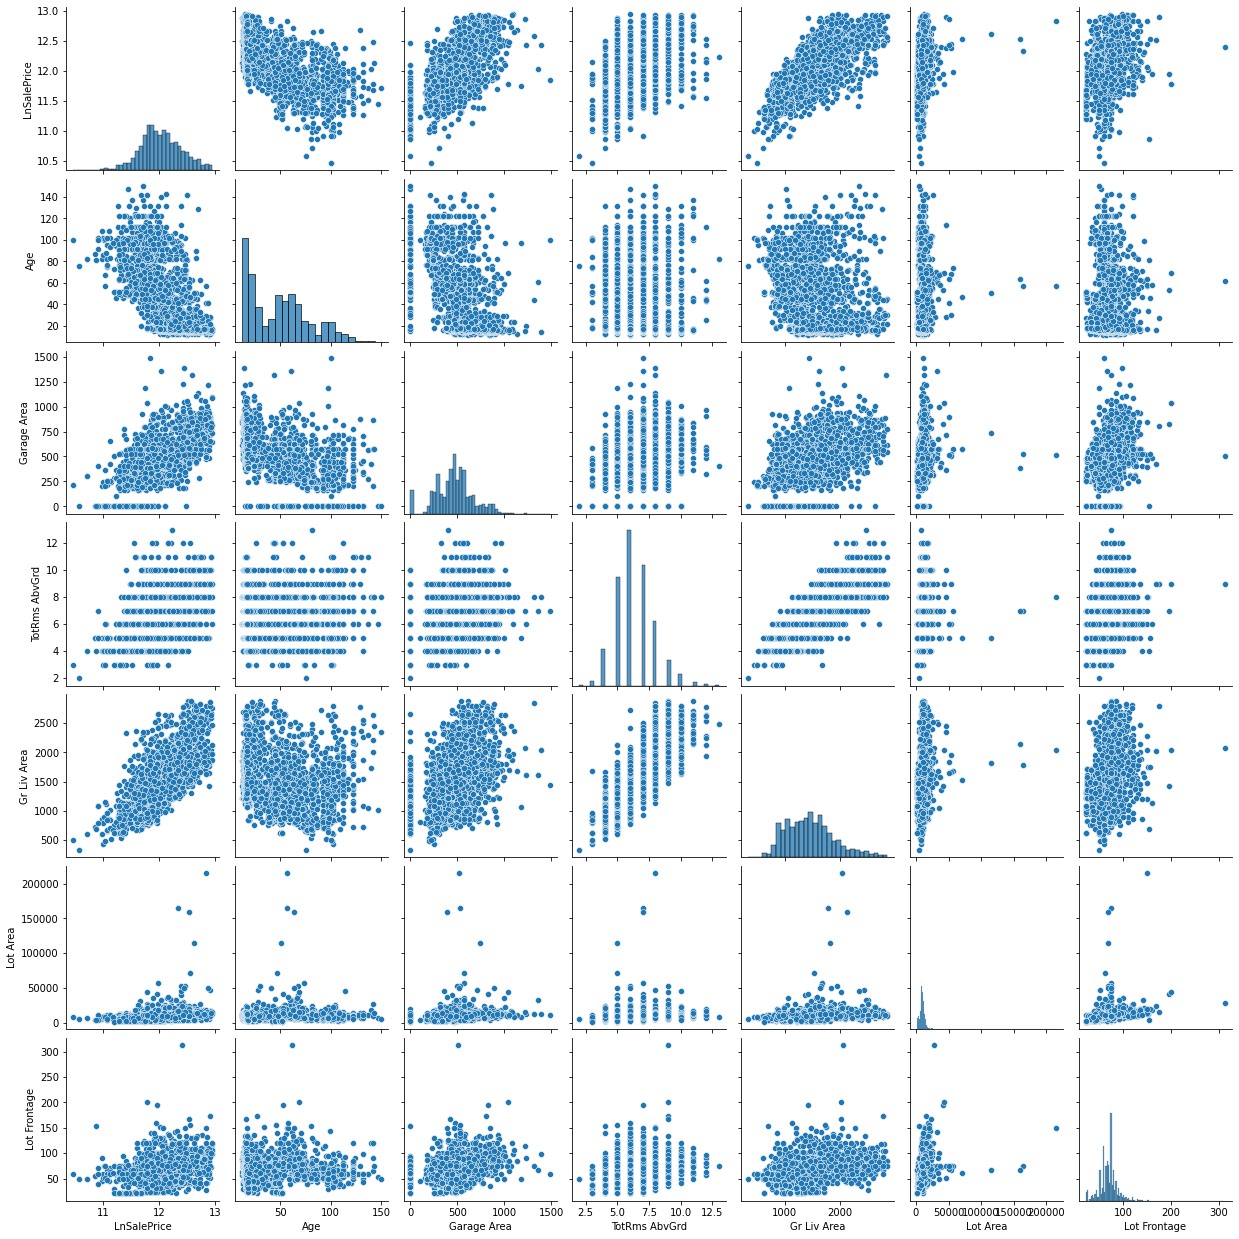

In [7]:
sns.pairplot(df[['LnSalePrice', 'Age', 'Garage Area', 'TotRms AbvGrd', 'Gr Liv Area', 'Lot Area', 'Lot Frontage']])

<AxesSubplot:>

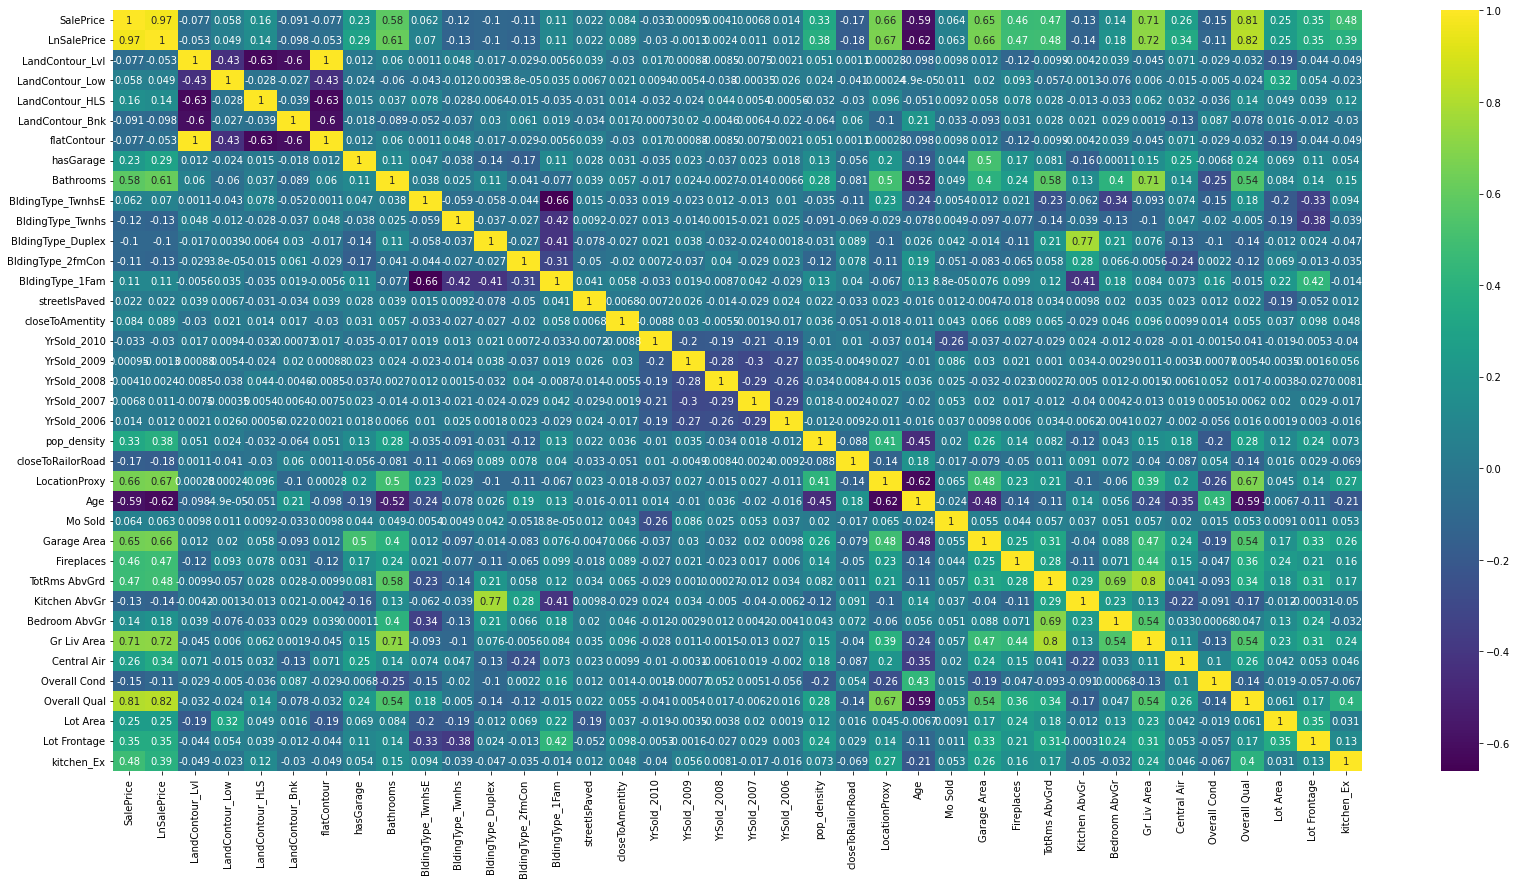

In [8]:
plt.figure(figsize=(28, 14))
sns.heatmap(df.corr(), annot=True, cmap="viridis")

From the above we see there is strong multicollinearity that exists between the following variables:

* Kitchen AbvGr and BldingType_Complex (0.77)
* TotRms AbvGrd and Gr Liv Area (0.8)
* Bathrooms and Gr Liv Area (0.71)

We'll drop all features on the left to remove this correlation. Other than the above we see there is correlation, both negative and positive, but nothing too strong that requires us to drop further variables.

In [9]:
df.drop(['Bathrooms', 'TotRms AbvGrd', 'Kitchen AbvGr'], axis=1, inplace=True)

Before we begin the splitting of data, we also have some further variables that need to be dropped:

We changed the land contour variable to a dummy variable but also have another binary variable for whether a property is built on flat land or not. We see from the above correlation between the feature and these variables there does not seem to be any clear correlation (range is between -0.10 - 0.10). Hence to reduce the complexity we'll keep the flat contour variable but remove the other dummy variable.

In [10]:
df.drop(['LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'], axis=1, inplace=True)

### Helper functions used for outputting model performance:

We'll be performing repetitive actions that can be simplified via the use of functions.

In [11]:
def test_scores(estimator, X, y):
    """
    Function used to output the model R-squared (score) on the test dataset
    
    params:
    ------- 
    estimator : the model object
    X         : the features used
    y         : the target used
    
    """
    print("Model          :", str(estimator).strip("()"))
    print("Test R-Squared :", np.round(estimator.score(X, y), 4))
    
    
def train_scores(estimator, X, y):
    """
    Function used to output the model R-squared (score) and cross validation scores
    
    params:
    ------- 
    estimator : the model object
    X         : the features used
    y         : the target used
    
    """
    cv_scores = cross_val_score(estimator, X, y)
    
    print("Training R-Squared :", np.round(estimator.score(X, y), 4))
    print("CV Scores          :", np.round(cv_scores, 4))
    print("Mean CV Scores     :", np.round(cv_scores.mean(), 4))

    
def acc_scores(estimator, X, y):
    """
    Function used to output the model score and cross validation scores
    
    params:
    ------- 
    estimator : the model object
    X         : the features used
    y         : the target used
    
    """
    y_pred = estimator.predict(X)
    print("Mean Square Error      :", np.round(metrics.mean_squared_error(y, y_pred), 4))
    print("Root Mean Square Error :", np.round(np.sqrt(metrics.mean_squared_error(y, y_pred)), 4))

#### Splitting the data:

While we created dummy variables for property sales before and after the financial crisis, we'll analyse both to determine a model's power from both angles. 

As displayed in the data_engineering notebook there is a significant decline in property prices in 2010 as a result of the crisis, hence we'll split data based on properties sold in 2010 (more recent data is not available) and those sold before:

In [12]:
# also as we didn't drop a variable in the dummy creation of BldingType_ , we'll drop a column now to create a consistent reference bin
df.drop('BldingType_1Fam', axis=1, inplace=True)

In [13]:
df_2006_2009 = df[df['YrSold_2010'] != 1]
df_2010 = df[df['YrSold_2010'] == 1]

In [14]:
# dropping years (new edit: major multicollinearity had big impact on modelling runs)
df_2006_2009 = df_2006_2009.drop(['YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010'], axis=1).copy()
df_2010 = df_2010.drop(['YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010'], axis=1).copy()

In [15]:
df_2006_2009.shape

(2297, 25)

In [16]:
df_2010.shape

(308, 25)

### Pre-2010 Regression Modelling.

As noted in the engineering notebook the logarithmic property prices were more appropiate and fitting of a gaussian distribution hence we'll be using them:

In [17]:
X = df_2006_2009.drop(['LnSalePrice', 'SalePrice'], axis=1)
y = df_2006_2009.LnSalePrice

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
# standardise our data to ensure features are fitted to the estimator on the same scale. 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [20]:
# fit the linear regression model 
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [21]:
lm.intercept_

12.034296301970853

In [22]:
lm.coef_

array([-0.00826859, -0.00062873,  0.00450171, -0.02131804, -0.01316178,
        0.00145576,  0.0082766 ,  0.00291186,  0.01692939, -0.0160702 ,
        0.02458811, -0.09342717,  0.00233403,  0.03610589,  0.02672092,
       -0.01539135,  0.12973323,  0.01884369,  0.0514485 ,  0.10897757,
        0.0299096 ,  0.01733699,  0.02233471])

In [23]:
train_scores(lm, X_train, y_train)

Training R-Squared : 0.9009
CV Scores          : [0.8768 0.9076 0.9142 0.8667 0.8987]
Mean CV Scores     : 0.8928


In [24]:
# run 5-fold corss val scores
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(lm, X_train, y_train, cv=kf)

print(np.round(cv_scores, 4))
print(np.round(cv_scores.mean(), 4))

[0.9177 0.8871 0.8965 0.8931 0.8769]
0.8943


In [25]:
# output the R-squared on the test data
test_scores(lm, X_test, y_test)

Model          : LinearRegression
Test R-Squared : 0.9052


In [26]:
# outputting the model accuracy scores (RMSE and MSE)
acc_scores(lm, X_test, y_test)

Mean Square Error      : 0.0128
Root Mean Square Error : 0.1133


In [27]:
# create variable for the model's coefficients
lm_coef = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=['coef'])
lm_coef['abs_coef'] = np.abs(lm.coef_)
lm_coef

,coef,abs_coef
flatContour,-0.008269,0.008269
hasGarage,-0.000629,0.000629
BldingType_TwnhsE,0.004502,0.004502
BldingType_Twnhs,-0.021318,0.021318
BldingType_Duplex,-0.013162,0.013162
BldingType_2fmCon,0.001456,0.001456
streetIsPaved,0.008277,0.008277
closeToAmentity,0.002912,0.002912
pop_density,0.016929,0.016929
closeToRailorRoad,-0.016070,0.016070


### Regression Residual Analysis

In [28]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

In [29]:
train_residuals_0609 = y_train - y_pred_train

In [30]:
train_residuals_0609.describe()

count    1.607000e+03
mean    -9.218927e-16
std      1.147066e-01
min     -4.774283e-01
25%     -6.902699e-02
50%     -2.440248e-03
75%      6.637871e-02
max      5.297907e-01
Name: LnSalePrice, dtype: float64

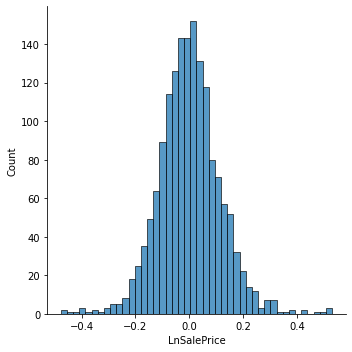

In [31]:
sns.displot(train_residuals_0609)

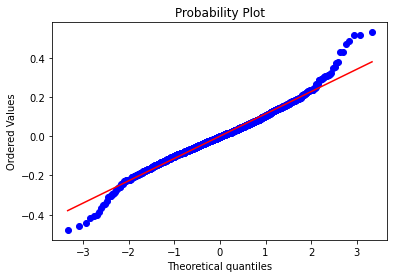

In [32]:
stats.probplot(train_residuals_0609, dist="norm", plot=plt)
plt.show()

The distribution above shows an approximately symmetric distribution with ~ equal skewness on either side of the mean near 0. This is highlighted by the Q-Q plot - clearly there is some skewness on either side of the average residual value but this appears to be equally dispersed with no tail being significantly 'fatter' than the other. We'll confirm this distribution's skewness value below:

In [33]:
print("Skewness : ", np.round(train_residuals_0609.skew(), 4))
print("Kurtosis : ", np.round(train_residuals_0609.kurtosis(), 4))

Skewness :  0.1963
Kurtosis :  1.8729


Skewness: while the normal distribution has a skewness of 0, a rule-of-thumb for this measure is that values within +- 0.5 are approximately symmetric. From the above we can see this rule holds true.
Kurtosis: normal distrbutions have a kurtosis value of exactly 3 however values between -2 and +2 are also considered acceptable in order to prove the distribution is normal. Here we can say this assumptions holds true as well. 

Formally test for normality using the Shapiro-Wilk test:

* Null hypothesis: the distribution *is* normally distributed.
* Alternative hypothesis: the distribution is *not* normally distributed.

In [34]:
stat, p = shapiro(train_residuals_0609)
print(f"Shapiro-Wilk test on normality = {np.round(stat, 4)}")
print(f"P-value = {np.round(p, 4)}")

Shapiro-Wilk test on normality = 0.982
P-value = 0.0


Using the formal Shapiro-Wilks test we actually reject the null-hypothesis at all levels of alpha as the p-value is significant, thus we conclude our data was not drawn from a normal distribution. Clearly the test has been significantly impacted by the tails on either side of the distribution.

#### Testing assumptions on test residuals:

In [35]:
test_residuals_0609 = y_test - y_pred_test

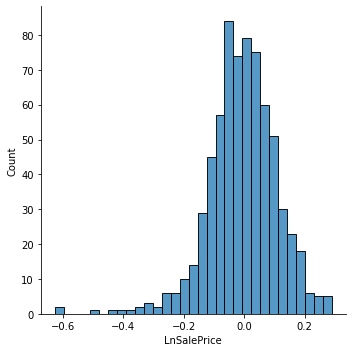

In [36]:
sns.displot(test_residuals_0609)

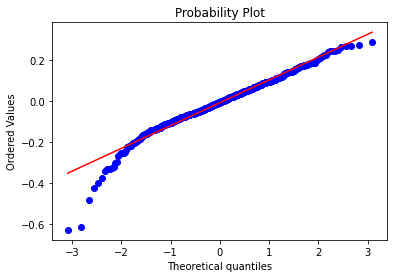

In [37]:
stats.probplot(test_residuals_0609, dist="norm", plot=plt)
plt.show()

In [38]:
print("Skewness : ", np.round(test_residuals_0609.skew(), 4))
print("Kurtosis : ", np.round(test_residuals_0609.kurtosis(), 4))

Skewness :  -0.7632
Kurtosis :  3.0101


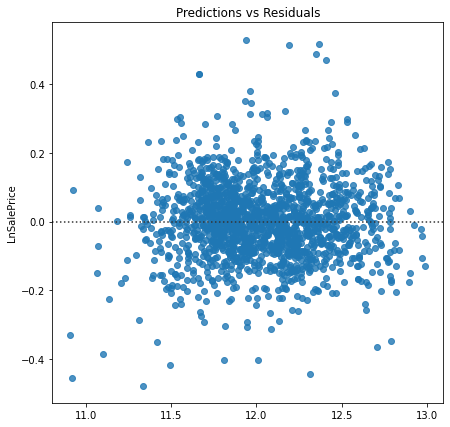

In [39]:
plt.figure(figsize=(7,7))
sns.residplot(x=y_pred_train, y=train_residuals_0609)
plt.title("Predictions vs Residuals")
plt.show()

The plots above show clear negative skewness and a less symetrical distribution than the train residuals, confirmed by the skewness value displayed above.

This is caused by variation and greater predictive errors on the left tail of the price distribution i.e., the model is not very precise at predicting properties at the bottom end of the scale.

We'll view this further through a residual plot:

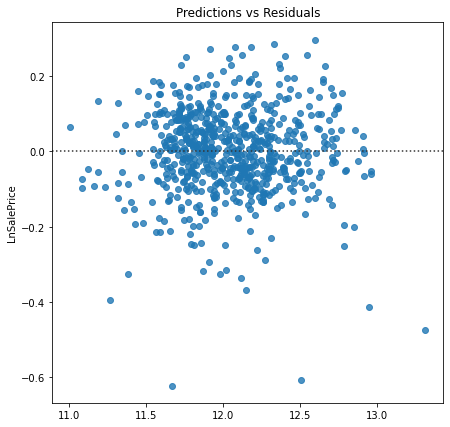

In [40]:
plt.figure(figsize=(7,7))
sns.residplot(x=y_pred_test, y=test_residuals_0609)
plt.title("Predictions vs Residuals")
plt.show()

Points under the line y=0 represent over estimates for property prices, while values above show under estimates.

We see that there is greater variation for estimations under the actual property prices which is likely a result of insufficient data for the cheapest property prices. Two solutions could be to either increase our test dataset or increase the cut off for property prices on the left tail of the distribution, although doing so would reduce the range of the model to make estimations.

In any case, our residuals appear random and cluster towards the middle of the plot (estimations are very close to actual values), consequently our residuals meet our assumption of independence.

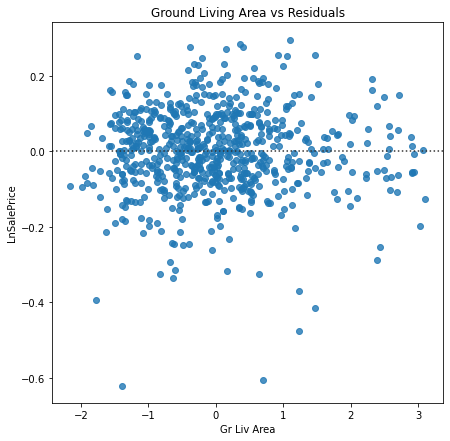

In [41]:
# plotting residuals against highly correlated feature to further check independence. Similar relationship displayed to the above where there is 
# greater variation in over-estimates, below y=0
plt.figure(figsize=(7,7))
sns.residplot(x=X_test['Gr Liv Area'], y=test_residuals_0609)
plt.title("Ground Living Area vs Residuals")
plt.show()

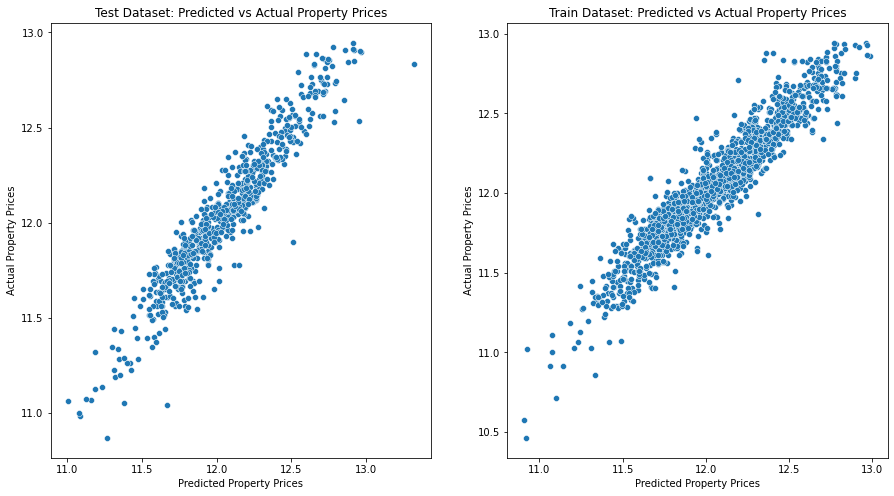

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

sns.scatterplot(x=y_pred_test, y=y_test, ax=ax[0])
ax[0].set_title("Test Dataset: Predicted vs Actual Property Prices")
ax[0].set_ylabel("Actual Property Prices")
ax[0].set_xlabel("Predicted Property Prices")

sns.scatterplot(x=y_pred_train, y=y_train, ax=ax[1])
ax[1].set_title("Train Dataset: Predicted vs Actual Property Prices")
ax[1].set_ylabel("Actual Property Prices")
ax[1].set_xlabel("Predicted Property Prices")

plt.show()

As above we see greater deviation in the bottom left corner of the test plot which represents model over estimations.

What we're seeing above is a case of slight over-fitting: our model is complex with lots of variables and appears to perform better on our training dataset than our testing dataset. We can see this through the residual plots above where residual values are spread more evenly in the train dataset compared to the test dataset. Above in the linear scatter plots we can also see slightly more variation in the test predictions than train predictions, meaning our data has not been as accurate in predicting prices on new data.

### Modelling with Ridge & Lasso regressions

To reduce overfitting and optimise the predictions, we can use Ridge and Lasso regressions which add bias to the regression function, allowing them to work better on new data sets. By adding a penalty, lambda, to large coefficients, any changes in these variables will be reduced compared to an ordinary least squares regression with no bias.

#### Ridge:

In [43]:
ridge_lm = RidgeCV(cv=5)  # default alphas: 0.1, 1, 10
ridge_lm.fit(X_train, y_train)

RidgeCV(cv=5)

In [44]:
print("Best Alpha: ", ridge_lm.alpha_)

Best Alpha:  10.0


In [45]:
# output training dataset score with cv scores
train_scores(ridge_lm, X_train, y_train)

Training R-Squared : 0.9009
CV Scores          : [0.8769 0.9075 0.914  0.8675 0.8991]
Mean CV Scores     : 0.893


In [46]:
# output testing dataset score
test_scores(ridge_lm, X_test, y_test)

Model          : RidgeCV(cv=5
Test R-Squared : 0.9052


In [47]:
# output accuracy scores for ridge regression
acc_scores(ridge_lm, X_test, y_test)

Mean Square Error      : 0.0128
Root Mean Square Error : 0.1133


In [48]:
# collect the coefficients of the ridge regression
ridge_lm_coef = pd.DataFrame(ridge_lm.coef_, index=X_train.columns, columns=['coef'])
ridge_lm_coef["abs_coef"] = np.abs(ridge_lm.coef_)

#### Lasso:

In [49]:
lasso_lm = LassoCV(cv=5)
lasso_lm.fit(X_train, y_train)

LassoCV(cv=5)

In [50]:
print("Best Alpha: ", lasso_lm.alpha_)

Best Alpha:  0.002441845801874551


In [51]:
# output training dataset score
train_scores(lasso_lm, X_train, y_train)

Training R-Squared : 0.9002
CV Scores          : [0.8749 0.9024 0.9158 0.8689 0.9018]
Mean CV Scores     : 0.8928


In [52]:
# output testing dataset score
test_scores(lasso_lm, X_test, y_test)

Model          : LassoCV(cv=5
Test R-Squared : 0.905


In [53]:
# output accuracy scores for lasso regression
acc_scores(lasso_lm, X_test, y_test)

Mean Square Error      : 0.0129
Root Mean Square Error : 0.1134


In [54]:
# collect the coefficients of the lasso regression
lasso_lm_coef = pd.DataFrame(lasso_lm.coef_, index=X_train.columns, columns=['coef'])
lasso_lm_coef["abs_coef"] = np.abs(lasso_lm.coef_)

### Inferences from all regression models:

There is stability across all three linear models with low variance in both the R-squared and RMSE values:

* R-squared range: 0.90 - 0.91  (train and test datasets)
* RMSE range: 0.1133 - 0.1134

### Comparison of the linear model coefficients: 

In [55]:
coef_df = pd.DataFrame(pd.concat([lm_coef.coef, ridge_lm_coef.coef, lasso_lm_coef.coef]))
coef_df.reset_index(inplace=True)

In [56]:
coef_df.loc[0:27, "model"] = "ols"
coef_df.loc[28:55, "model"] = "ridge"
coef_df.loc[56:84, "model"] = "lasso"

coef_df.rename({"index": "variable"}, axis=1, inplace=True)

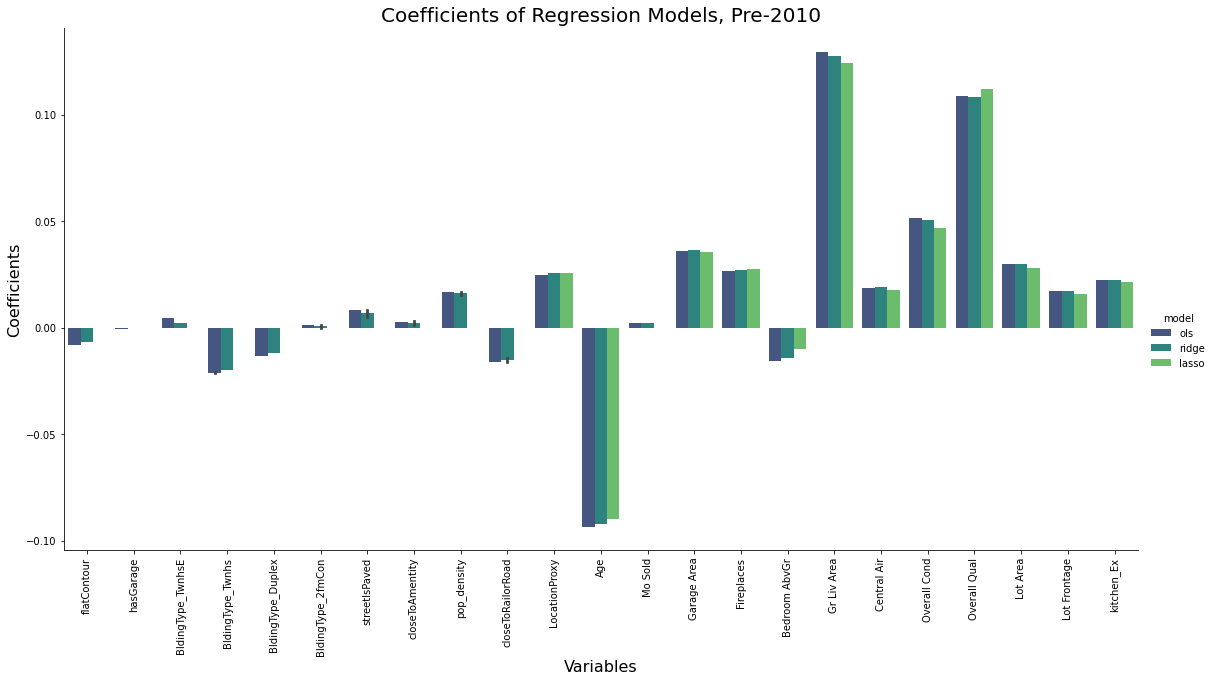

In [57]:
w = sns.catplot(x='variable', y='coef', hue='model', data=coef_df, palette="viridis", kind='bar', height=8, aspect=2)
# set rotation
w.set_xticklabels(rotation=90)

plt.title('Coefficients of Regression Models, Pre-2010', fontsize=20)
plt.xlabel("Variables", size=16)
plt.ylabel("Coefficients", size=16)
plt.show()

All three models clearly display the 4 most significant variables based on their magnitude: ground living area, overall quality, age and overall condition.

### Now modelling on post 2009 dataset to compare the performance differences

In [58]:
X = df_2010.drop(['LnSalePrice', 'SalePrice'], axis=1)
y = df_2010.LnSalePrice

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# standardise our data to ensure features are fitted to the estimaor on the same scale. 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [61]:
# fit the linear regression model 
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [62]:
lm.intercept_

12.010520862004773

In [63]:
lm.coef_

array([ 6.68397114e-03, -6.21731112e-03, -3.49034018e-02, -2.74853624e-02,
       -4.77010400e-03, -2.30959839e-02, -2.42861287e-17, -1.16970323e-02,
        3.02627583e-02, -9.83555551e-03,  2.36868916e-03, -9.15670570e-02,
       -8.40050914e-03,  5.13909395e-02,  2.92238445e-02, -4.32239963e-02,
        1.40151277e-01,  1.61217487e-02,  5.54078063e-02,  1.04658881e-01,
        2.46327774e-02, -2.16457613e-03,  3.05517719e-02])

In [64]:
train_scores(lm, X_train, y_train)

Training R-Squared : 0.9034
CV Scores          : [0.91   0.8956 0.7697 0.8241 0.87  ]
Mean CV Scores     : 0.8539


In [65]:
# output the R-squared on the test data
test_scores(lm, X_test, y_test)

Model          : LinearRegression
Test R-Squared : 0.8613


In [66]:
# outputting the model accuracy scores (RMSE and MSE)
acc_scores(lm, X_test, y_test)

Mean Square Error      : 0.0168
Root Mean Square Error : 0.1295


Training score above is marginally higher than 2006-2009 dataset (+0.025) however the test score is significantly smaller than the pre-2010 dataset (post-2009 test dataset is approx. 13.37% of the pre-2010 test data) therefore this outcome is expected. 

In [67]:
# create variable for the model's coefficients
lm_coef = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=['coef'])
lm_coef['abs_coef'] = np.abs(lm.coef_)

In [68]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

In [69]:
test_residuals_10 = y_test - y_pred_test
train_residuals_10 = y_train - y_pred_train

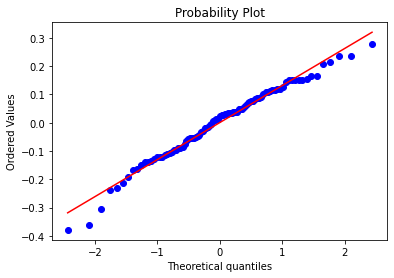

In [70]:
stats.probplot(test_residuals_10, dist="norm", plot=plt)
plt.show()

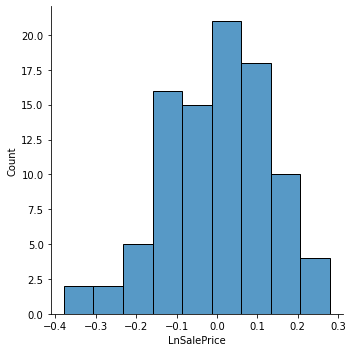

In [71]:
sns.displot(test_residuals_10)

In [72]:
print("Skewness : ", np.round(test_residuals_10.skew(), 4))
print("Kurtosis : ", np.round(test_residuals_10.kurtosis(), 4))

Skewness :  -0.4768
Kurtosis :  0.2927


Similarly to the pre-2010 data, the residual distribution appears to be approximately normal with acceptable skewness and kurtosis.

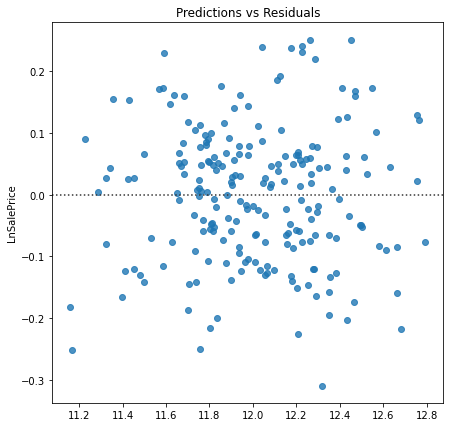

In [73]:
plt.figure(figsize=(7,7))
sns.residplot(x=y_pred_train, y=train_residuals_10)
plt.title("Predictions vs Residuals")
plt.show()

The independence assumption also holds true for residuals - data appears to be random with an even number of points above and below the line y=0.

### Modelling with Ridge & Lasso regressions:

#### Ridge:

In [74]:
ridge_lm = RidgeCV(cv=5)  # default alphas: 0.1, 1, 10
ridge_lm.fit(X_train, y_train)

RidgeCV(cv=5)

In [75]:
print("Best Alpha: ", ridge_lm.alpha_)

Best Alpha:  10.0


In [76]:
# output training dataset score with cv scores
train_scores(ridge_lm, X_train, y_train)

Training R-Squared : 0.9021
CV Scores          : [0.9094 0.8963 0.7704 0.8232 0.8771]
Mean CV Scores     : 0.8553


In [77]:
# output testing dataset score
test_scores(ridge_lm, X_test, y_test)

Model          : RidgeCV(cv=5
Test R-Squared : 0.871


In [78]:
# output accuracy scores for ridge regression
acc_scores(ridge_lm, X_test, y_test)

Mean Square Error      : 0.0156
Root Mean Square Error : 0.1248


In [79]:
# collect the coefficients of the ridge regression
ridge_lm_coef = pd.DataFrame(ridge_lm.coef_, index=X_train.columns, columns=['coef'])
ridge_lm_coef["abs_coef"] = np.abs(ridge_lm.coef_)

#### Lasso:

In [80]:
lasso_lm = LassoCV(cv=5)
lasso_lm.fit(X_train, y_train)

LassoCV(cv=5)

In [81]:
print("Best Alpha: ", lasso_lm.alpha_)

Best Alpha:  0.002600629895573021


In [82]:
# output training dataset score
train_scores(lasso_lm, X_train, y_train)

Training R-Squared : 0.9023
CV Scores          : [0.908  0.8899 0.7842 0.8328 0.8772]
Mean CV Scores     : 0.8584


In [83]:
# output testing dataset score
test_scores(lasso_lm, X_test, y_test)

Model          : LassoCV(cv=5
Test R-Squared : 0.8654


In [84]:
acc_scores(lasso_lm, X_test, y_test)

Mean Square Error      : 0.0163
Root Mean Square Error : 0.1275


### Inferences from all regression models:

Looking specifically at post-2009 data, models appear stable with a range of 0.86-0.87 for R-squared test data. Both the Ridge and Lasso marginally outperformed OLS in this section, improving the R-squared score by ~ +0.5.

RMSE also appeared stable with a range of 0.1248-0.1295. As expected from the slight outperformance, the errors were less than the OLS model.

Comparing pre-2010 to post-2009 data, there is a clear outperformance on data before the financial crisis. For both OLS models, the R-squared values are 0.91 and 0.86 for pre-2010 and post-2009, respectively. 

This can be attributed to the lack of data for properties sold in 2010 compared to before this year. Of the total dataset, sales before 2010 amount to 88% of the dataset (2,297 rows).

Moreover, it could be argued that, as a result of economic conditions, there may be greater variance in the sales that ocurred due to simple laws of economics i.e, lack of demand may have lead some homeowners to sell their properties below market value due to personal reasons e.g, require the funds as soon as possible. Hence the variance may have caused some of the over-estimations.

In conclusion of model choice, while the residual distributions appear to be negatively skewed for test data, they look approximately normal and fit our rules for skewness and kurtosis, hence we will be proceeding with the OLS regression model.

### Comparison of the linear model coefficients: 

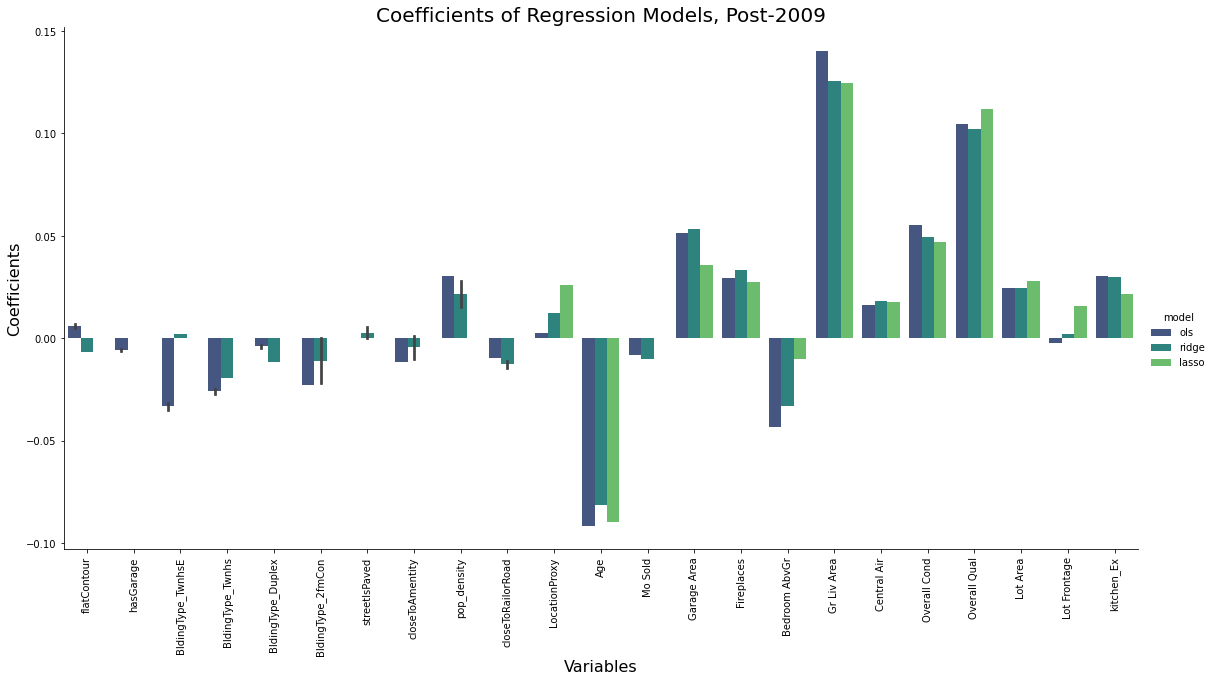

In [85]:
coef_df = pd.DataFrame(pd.concat([lm_coef.coef, ridge_lm_coef.coef, lasso_lm_coef.coef]))
coef_df.reset_index(inplace=True)

coef_df.loc[0:27, "model"] = "ols"
coef_df.loc[28:55, "model"] = "ridge"
coef_df.loc[56:84, "model"] = "lasso"

coef_df.rename({"index": "variable"}, axis=1, inplace=True)

# plot
w = sns.catplot(x='variable', y='coef', hue='model', data=coef_df, palette="viridis", kind='bar', height=8, aspect=2)
# set rotation
w.set_xticklabels(rotation=90)

plt.title('Coefficients of Regression Models, Post-2009', fontsize=20)
plt.xlabel("Variables", size=16)
plt.ylabel("Coefficients", size=16)
plt.show()

Interestingly, for post-2009 sales the size of the property's garage/s and number of fireplaces appears to have a greater impact on the price of the property than pre-2010. 

### Final section: regression modelling using the full dataset (sales from 2006 to 2010)

In [86]:
y = df.LnSalePrice
X = df.drop(['LnSalePrice', 'SalePrice'], axis=1)

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2605
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flatContour        2605 non-null   int64  
 1   hasGarage          2605 non-null   int64  
 2   BldingType_TwnhsE  2605 non-null   int64  
 3   BldingType_Twnhs   2605 non-null   int64  
 4   BldingType_Duplex  2605 non-null   int64  
 5   BldingType_2fmCon  2605 non-null   int64  
 6   streetIsPaved      2605 non-null   int64  
 7   closeToAmentity    2605 non-null   int64  
 8   YrSold_2010        2605 non-null   int64  
 9   YrSold_2009        2605 non-null   int64  
 10  YrSold_2008        2605 non-null   int64  
 11  YrSold_2007        2605 non-null   int64  
 12  YrSold_2006        2605 non-null   int64  
 13  pop_density        2605 non-null   int64  
 14  closeToRailorRoad  2605 non-null   int64  
 15  LocationProxy      2605 non-null   int64  
 16  Age                2605 

In [88]:
# performing standardisation of data before final model run
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,flatContour,hasGarage,BldingType_TwnhsE,BldingType_Twnhs,BldingType_Duplex,BldingType_2fmCon,streetIsPaved,closeToAmentity,YrSold_2010,YrSold_2009,YrSold_2008,YrSold_2007,YrSold_2006,pop_density,closeToRailorRoad,LocationProxy,Age,Mo Sold,Garage Area,Fireplaces,Bedroom AbvGr,Gr Liv Area,Central Air,Overall Cond,Overall Qual,Lot Area,Lot Frontage,kitchen_Ex
0,0.323651,0.216854,-0.306722,-0.192412,-0.190256,-0.142717,0.048048,-0.141311,2.730896,-0.536962,-0.518531,-0.563607,-0.507786,0.253688,-0.359405,-0.468745,0.425524,-0.446863,0.267155,2.204677,0.201624,0.399639,0.241894,-0.551641,-0.082467,2.779751,3.476785,-0.248057
1,0.323651,0.216854,-0.306722,-0.192412,-0.190256,-0.142717,0.048048,-0.141311,2.730896,-0.536962,-0.518531,-0.563607,-0.507786,-3.982580,2.782375,-0.468745,0.391778,-0.071233,1.257761,-0.943135,-1.042998,-1.300979,0.241894,0.370120,-0.830992,0.211707,0.519649,-0.248057
2,0.323651,0.216854,-0.306722,-0.192412,-0.190256,-0.142717,0.048048,-0.141311,2.730896,-0.536962,-0.518531,-0.563607,-0.507786,0.253688,-0.359405,-0.468745,0.493016,-0.071233,-0.792106,-0.943135,0.201624,-0.332074,0.241894,0.370120,-0.082467,0.548836,0.568126,-0.248057
3,0.323651,0.216854,-0.306722,-0.192412,-0.190256,-0.142717,0.048048,-0.141311,2.730896,-0.536962,-0.518531,-0.563607,-0.507786,0.253688,-0.359405,-0.468745,0.155556,-0.822494,0.237731,2.204677,0.201624,1.415535,0.241894,-0.551641,0.666058,0.152821,1.149858,4.031334
4,0.323651,0.216854,-0.306722,-0.192412,-0.190256,-0.142717,0.048048,-0.141311,2.730896,-0.536962,-0.518531,-0.563607,-0.507786,0.253688,-0.359405,0.553936,-0.823079,-1.198124,0.041572,0.630771,0.201624,0.339223,0.241894,-0.551641,-0.830992,0.493137,0.228783,-0.248057


In [89]:
final_lm = LinearRegression()

In [90]:
final_lm.fit(X, y)

LinearRegression()

In [91]:
# output test scores
test_scores(final_lm, X, y)

Model          : LinearRegression
Test R-Squared : 0.9016


In [92]:
# output the accuracy metrics, mse and rmse
acc_scores(final_lm, X, y)

Mean Square Error      : 0.013
Root Mean Square Error : 0.1142


In [93]:
# save coefficients to variable
final_coef = pd.DataFrame(data=final_lm.coef_, index=X.columns, columns=['coef'])
final_coef

,coef
flatContour,-8.365311e-03
hasGarage,-2.108264e-03
BldingType_TwnhsE,-5.751806e-03
BldingType_Twnhs,-2.372819e-02
BldingType_Duplex,-1.081502e-02
BldingType_2fmCon,9.470235e-04
streetIsPaved,3.782180e-03
closeToAmentity,1.625022e-03
YrSold_2010,-2.416564e+10
YrSold_2009,-3.119372e+10


In [94]:
y_pred = final_lm.predict(X)
residuals = y - y_pred

In [95]:
residuals.describe()

count    2605.000000
mean        0.000004
std         0.114199
min        -0.629179
25%        -0.070386
50%         0.000482
75%         0.070031
max         0.550551
Name: LnSalePrice, dtype: float64

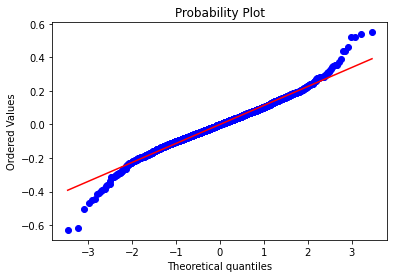

In [96]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

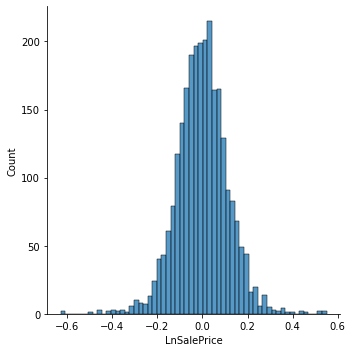

In [97]:
sns.displot(residuals)
plt.show()

In [98]:
print("Skewness : ", np.round(residuals.skew(), 4))
print("Kurtosis : ", np.round(residuals.kurtosis(), 4))

Skewness :  -0.0424
Kurtosis :  2.0679


In [99]:
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test on normality = {np.round(stat, 4)}")
print(f"P-value = {np.round(p, 4)}")

Shapiro-Wilk test on normality = 0.983
P-value = 0.0


Residuals appear to fail the formal Shapiro-Wilks test for normality as the null-hypothesis cannot be rejected, a result of the "fat" tails. However, from the visual QQ-plot we can assume the data is normally distribution: it appears to be symmetrical and has acceptable values of skewness and kurtosis (skewness of -0.03 very close to a gaussian distribution that has a skewness of 0).

### Formal statistical inference:

Below we'll be using statsmodels to output the OLS regression results formally which includes hypothesis tests of coefficients to determine if they are statistically significant or not i.e., if they are significant statistically in predicting the price of a property. Note in this case we'll be using the unstandardised feature values and will add a constant to our features, required in our dataset as our y-intercept value:

In [100]:
X = df.drop(['LnSalePrice', 'SalePrice', 
             'YrSold_2006','YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010'], axis=1)

In [101]:
X = sm.add_constant(X)

In [102]:
final_model = sm.OLS(y, X)
results = final_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            LnSalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1021.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:28:04   Log-Likelihood:                 1948.7
No. Observations:                2605   AIC:                            -3849.
Df Residuals:                    2581   BIC:                            -3709.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.5778      0.05

**Inferences from the above:**

* R-squared, the coefficient of determination, has a high score of 0.901. This means that approximately 90% of the variance in y, the price of a property, can be explained by our model.
* As shown by the p-value column, most variables are statistically significant with a confidence interval of 99%. This means that we can reject the null hypothesis confirming these variables are good predictors of a property's value.
* Features that are not statistically significant with a confidence level of 90% are: hasGarage, BldingType_2fmCon, streetIsPaved, closeToAmentity and Mo Sold. In these cases we must accept the null-hypothesis, that is these variables do not have a significant influence on y and thus are not good predictiors.
* Our coefficient visuals, displaying the strongest predictors, are confirmed by the above results through their p-values.

Finally output the transformed coefficients based on 1-unit change:

In [103]:
final_lm.fit(X.drop('const', axis=1), y)

LinearRegression()

In [104]:
# get coefficients
coefs = final_lm.coef_

transformed_coefs = []
for coef in coefs:
    transformed_coefs.append(math.exp(coef))

print(transformed_coefs)

[0.9719002361280606, 0.9888814890142242, 0.9815561985384202, 0.8810800320421925, 0.9412699517952412, 1.0085448780950894, 1.0773478302834163, 1.0104680419353917, 1.0411920886581134, 0.9465620786774674, 1.0267655764044565, 0.9968544249749466, 1.0002641235042533, 1.0002033729348168, 1.0473496786916034, 0.9764171329286102, 1.0002971875588496, 1.0920589447409956, 1.0487618312554798, 1.078802493809259, 1.000003378735699, 1.000779151161234, 1.1076573221524357]


In [105]:
coef_effect = [(i - 1) * df.SalePrice.mean() for i in transformed_coefs]

In [106]:
var_impact = pd.DataFrame([X.columns.drop('const'), coef_effect]).T
var_impact.rename({0: 'feature', 1: '1-unit change'}, axis=1, inplace=True)

In [107]:
var_impact.sort_values(by="1-unit change", ascending=False)

,feature,1-unit change
22,kitchen_Ex,19311.330006
17,Central Air,16513.327903
19,Overall Qual,14135.415342
6,streetIsPaved,13874.481048
18,Overall Cond,8746.788386
14,Fireplaces,8493.479613
8,pop_density,7388.944865
10,LocationProxy,4801.149317
7,closeToAmentity,1877.733983
5,BldingType_2fmCon,1532.761149


Note initially the above 1-unit changes are based on the assumption of ceteris-parabus, that is, that if a feature moves by 1-unit all other features are constant and do not also change.

Examples of above (assuming 'all else being equal'):
* A property that has a 1-unit increase in the location proxy (the variable we created) will increase its value by ~ **$4,800**. 
* A property that has a 1-unit increase in its age will decrease in value by approximtely **560**.